# Linear Model Selection & Regularization

### Loading Libraries

In [16]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

# StatsModel
from statsmodels .api import OLS

# Scikit-Learn
import sklearn. linear_model as skl
from sklearn. pipeline import Pipeline
from sklearn. decomposition import PCA
import sklearn. model_selection as skm
from sklearn. preprocessing import StandardScaler
from sklearn. cross_decomposition import PLSRegression

In [3]:
# ISLP - Custom Libraries
from ISLP import load_data
from functools import partial
from ISLP.models import ModelSpec as MS
from ISLP.models import \
(Stepwise ,
sklearn_selected ,
sklearn_selection_path )

In [3]:
!pip install l0bnb

# !pip install git+https://github.com/joshmaxey/l0bnb
from l0bnb import fit_path

ModuleNotFoundError: No module named 'l0bnb'

### Subset Selection Methods

#### Forward Selection

In [4]:
Hitters = load_data('Hitters')

np.isnan(Hitters['Salary']).sum()

np.int64(59)

In [5]:
Hitters = Hitters.dropna ();
Hitters.shape

(263, 20)

In [6]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator .predict(X)
    RSS = np.sum ((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [7]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)

Y = np.array(Hitters['Salary'])
X = design. transform (Hitters)

sigma2 = OLS(Y, X).fit().scale

In [8]:
neg_Cp = partial(nCp , sigma2)

In [9]:
strategy = Stepwise . first_peak (design ,
direction ='forward ',
max_terms =len(design.terms))

In [10]:
hitters_MSE = sklearn_selected(OLS, strategy )
hitters_MSE.fit(Hitters, Y)

hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [12]:
hitters_Cp = sklearn_selected (OLS, strategy, scoring=neg_Cp)

hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

#### Choosing Among Models Using the Validation Set Approach & Cross-Validation

In [13]:
strategy=Stepwise.fixed_steps(design, len(design.terms), direction ='forward')

full_path=sklearn_selection_path(OLS, strategy)

In [14]:
full_path .fit(Hitters , Y)
Yhat_in = full_path .predict(Hitters)
Yhat_in.shape

(263, 20)

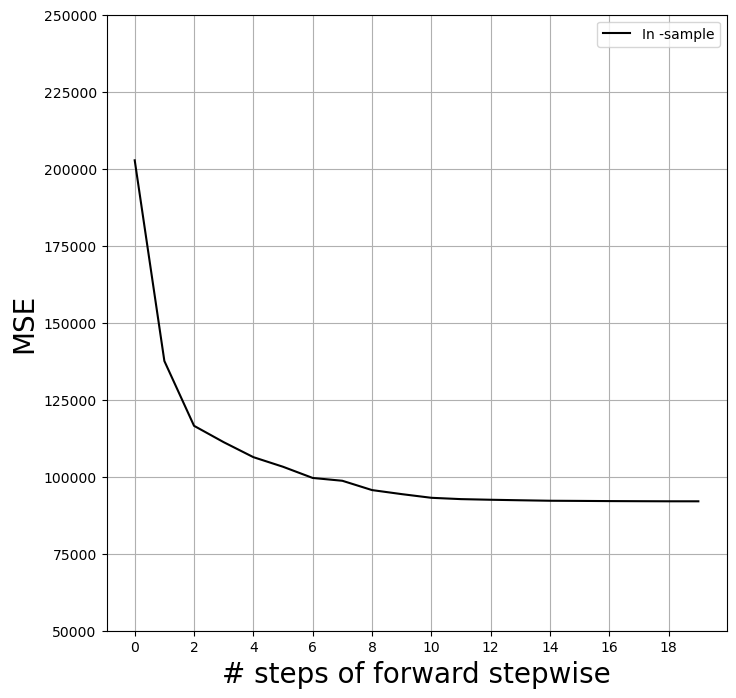

In [17]:
mse_fig, ax=subplots (figsize=(8 ,8))

insample_mse=(( Yhat_in - Y[:, None]) **2).mean (0)
n_steps = insample_mse .shape[0]
ax.plot(np.arange(n_steps), insample_mse ,'k', label='In -sample')
ax. set_ylabel ('MSE', fontsize =20)
ax. set_xlabel('# steps of forward stepwise',
fontsize =20)
ax. set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax. set_ylim([50000 ,250000]);
plt.grid(True)
plt.show()

In [18]:
K = 5

kfold = skm.KFold(K,
                  random_state =0,
                  shuffle=True)

Yhat_cv = skm. cross_val_predict (full_path,
                                  Hitters,
                                  Y,
                                  cv=kfold)
Yhat_cv.shape

(263, 20)

In [21]:
cv_mse = []

for train_idx , test_idx in kfold.split(Y):
    errors = (Yhat_cv[ test_idx ] - Y[test_idx ,None ]) **2
    cv_mse.append(errors.mean (0)) # Column Means

cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

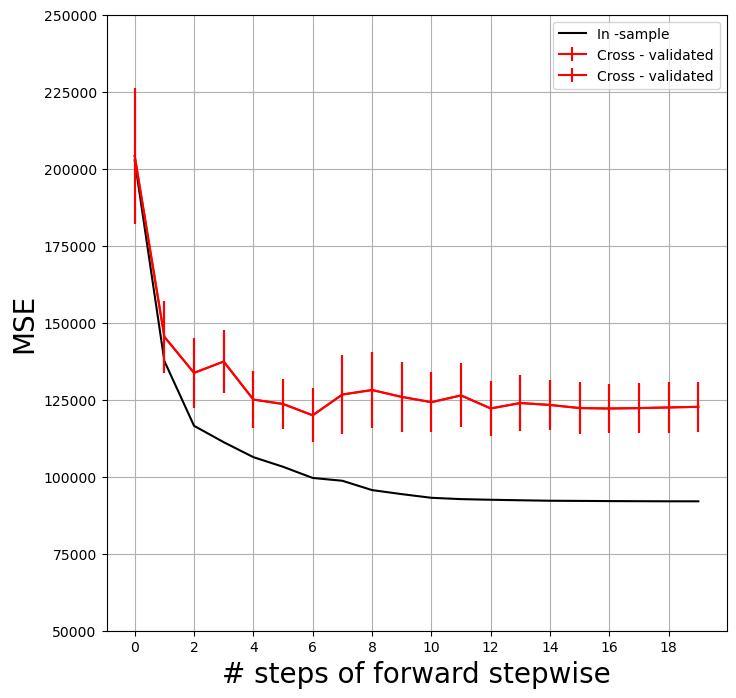

In [23]:
ax. errorbar(np.arange(n_steps),
             cv_mse.mean (1),
             cv_mse.std (1) / np.sqrt(K),
             label='Cross - validated',
             c='r')

ax. set_ylim ([50000 ,250000])
ax.legend ()
mse_fig
# plt.grid(True)
# plt.show()

In [24]:
validation = skm. ShuffleSplit (n_splits =1,
                                test_size =0.2,
                                random_state =0)

for train_idx , test_idx in validation .split(Y):
    full_path .fit(Hitters.iloc[train_idx],
                   Y[ train_idx])

Yhat_val = full_path .predict(Hitters.iloc[ test_idx])
errors = ( Yhat_val - Y[test_idx ,None])**2
validation_mse = errors.mean(0)

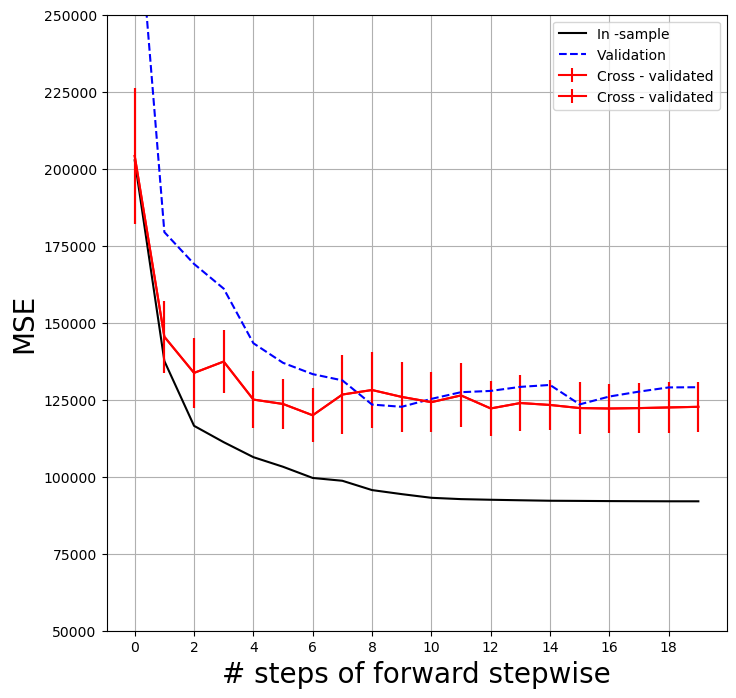

In [25]:
ax.plot(np.arange(n_steps),
        validation_mse,
        'b--', 
        label='Validation ')

ax. set_xticks(np.arange(n_steps)[::2])
ax. set_ylim([50000 ,250000])
ax.legend()
mse_fig

#### Best Subset Selection

In [26]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis =1)

X = np.asarray(D)

In [30]:
# path = fit_path(X,
#                 Y,
#                 max_nonzeros =X.shape[1])

In [31]:
# path[3]

### Ridge Regression and the Lasso

#### Ridge Regression

In [ ]:
Xs = X - X.mean(0)[None, :]
X_scale = X.std(0)
Xs = Xs / X_scale[None, :]
lambdas = 10** np.linspace(8, -2, 100) / Y.std()
soln_array = skl. ElasticNet.path(Xs ,
                                   Y,
                                   l1_ratio =0.,
                                   alphas=lambdas)[1]

soln_array .shape

In [ ]:
soln_path= pd.DataFrame(soln_array.T,
columns= D.columns,
                        index=-np.log(lambdas))

soln_path .index.name = 'negative log(lambda)'
soln_path

In [ ]:
path_fig , ax = subplots(figsize=(8, 8))

soln_path .plot(ax=ax, legend=False)
ax. set_xlabel ('$-\ log (\ lambda)$', fontsize =20)
ax. set_ylabel ('Standardized coefficients', fontsize =20)
ax.legend(loc='upper left');
plt.grid(True)
plt.show()

In [ ]:
beta_hat = soln_path .loc[ soln_path .index [39]]
lambdas[39], beta_hat

In [ ]:
np.linalg.norm(beta_hat)

In [ ]:
beta_hat = soln_path.loc[soln_path.index [59]]

lambdas[59], np.linalg.norm(beta_hat)

In [ ]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio =0)
scaler = StandardScaler(with_mean =True, with_std =True)

pipe = Pipeline(steps =[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

In [ ]:
np.linalg.norm(ridge.coef_)

#### Estimating Test Error of Ridge Regression

In [ ]:
validation = skm. ShuffleSplit (n_splits =1,
test_size =0.5 ,
random_state =0)
ridge.alpha = 0.01
results = skm. cross_validate (ridge ,
X,
Y,
scoring='neg_mean_squared_error ',
cv= validation )
-results['test_score ']

In [ ]:
ridge.alpha = 1e10

results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv= validation)

-results['test_score ']

In [ ]:
param_grid = {'ridge__alpha': lambdas}

grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')

grid.fit(X, Y)
grid. best_params_ ['ridge__alpha']
grid. best_estimator_

In [33]:
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')

grid.fit(X, Y)
grid. best_params_['ridge__alpha']
grid. best_estimator_

In [ ]:
ridge_fig , ax = subplots (figsize =(8 ,8))

ax. errorbar (-np.log(lambdas), -grid. cv_results_ ['mean_test_score'], yerr=grid. cv_results_ ['std_test_score'] / np.sqrt(K))
ax. set_ylim ([50000 ,250000])
ax. set_xlabel('$-\ log (\ lambda)$', fontsize =20)
ax. set_ylabel('Cross - validated MSE', fontsize =20);

In [ ]:
grid_r2 = skm. GridSearchCV (pipe,
                             param_grid,
                             cv=kfold)

grid_r2.fit(X, Y)

In [ ]:
r2_fig , ax = subplots(figsize =(8 ,8))

ax. errorbar (-np.log(lambdas),
              grid_r2. cv_results_ ['mean_test_score'],
              yerr=grid_r2. cv_results_ ['std_test_score'] / np.sqrt(K))

ax. set_xlabel ('$-\ log (\ lambda)$', fontsize =20)
ax. set_ylabel ('Cross - validated $R^2$', fontsize =20);

#### Fast Cross-Validation for Solution Paths

In [ ]:
ridgeCV= skl.ElasticNetCV(alphas=lambdas,
                            l1_ratio=0,
                            cv=kfold)

pipeCV= Pipeline (steps =[('scaler', scaler),
                           ('ridge ', ridgeCV)])

pipeCV.fit(X, Y)

In [ ]:
tuned_ridge = pipeCV. named_steps['ridge']
ridgeCV_fig , ax = subplots (figsize=(8 ,8))
ax. errorbar (-np.log(lambdas),
              tuned_ridge .mse_path_.mean(1),
              yerr= tuned_ridge.mse_path_ .std(1) / np.sqrt(K))

ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax. set_ylim ([50000 ,250000])
ax. set_xlabel ('$-\ log (\ lambda)$', fontsize =20)
ax. set_ylabel ('Cross - validated MSE', fontsize =20);

In [ ]:
np.min(tuned_ridge.mse_path_.mean(1))

In [ ]:
tuned_ridge.coef_

### Evaluating Test Error of Cross-Validated Ridge

In [ ]:
outer_valid= skm.ShuffleSplit(n_splits =1,
                              test_size =0.25,
                              random_state =1)

inner_cv= skm.KFold(n_splits =5,
                     shuffle=True ,
                     random_state =2)

ridgeCV= skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio =0,
                           cv= inner_cv)
pipeCV= Pipeline (steps=[('scaler', scaler),
                         ('ridge ', ridgeCV)]);

In [ ]:
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')

-results['test_score']

#### The Lasso

In [ ]:
lassoCV = skl.ElasticNetCV(n_alphas =100,
                           l1_ratio =1,
                           cv=kfold)

pipeCV= Pipeline(steps=[('scaler', scaler),
                        ('lasso ', lassoCV)])

pipeCV.fit(X, Y)
tuned_lasso= pipeCV.named_steps['lasso']
tuned_lasso.alpha_

In [ ]:
lambdas, soln_array= skl.Lasso.path(Xs,
                                    Y,
                                    l1_ratio =1,
                                    n_alphas =100) [:2]

soln_path = pd.DataFrame( soln_array.T,
                          columns=D.columns ,
                          index=-np.log(lambdas))

In [ ]:
path_fig, ax= subplots(figsize=(8 ,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax. set_xlabel ('$-\ log (\ lambda)$', fontsize =20)
ax. set_ylabel ('Standardized coefficiients', fontsize =20);

In [ ]:
np.min(tuned_lasso.mse_path_ .mean(1))

In [ ]:
lassoCV_fig, ax= subplots(figsize=(8 ,8))

ax. errorbar(-np.log(tuned_lasso.alphas_),
             tuned_lasso.mse_path_.mean(1),
             yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log( tuned_lasso .alpha_), c='k', ls='--')
ax. set_ylim([50000 ,250000])
ax. set_xlabel('$-\ log (\ lambda)$', fontsize =20)
ax. set_ylabel('Cross - validated MSE', fontsize =20);

In [ ]:
tuned_lasso.coef_

In [ ]:
### PCR and PLS Regression

#### Principal Components Regression